## Importing Data and libraries

In [ ]:
%%capture
!gdown https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

In [ ]:
%%capture
!unzip ninjacart_data.zip
print('Unzip Complete')

In [ ]:
# Import common libraries
import os
import glob
import random
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import tensorflow and its modules
import tensorflow as tf
from tensorflow import keras # this allows <keras.> instead of <tf.keras.>
from tensorflow.keras import layers, models # this allows <layers.> instead of <tf.keras.layers.>
tf.keras.utils.set_random_seed(111) # set random seed

from sklearn.metrics import confusion_matrix

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!ls ninjacart_data/train

'indian market'   onion   potato   tomato


## Data Exploration

In [ ]:
class_dirs = os.listdir("ninjacart_data/train")

count_dict = {cls: len(file_paths := glob.glob(f'ninjacart_data/train/{cls}/*')) for cls in class_dirs}
image_dict = {cls: tf.keras.utils.load_img(random.choice(file_paths)) for cls, file_paths in map(lambda cls: (cls, glob.glob(f'ninjacart_data/train/{cls}/*')), class_dirs)}

In [ ]:
class_names= class_dirs.copy()

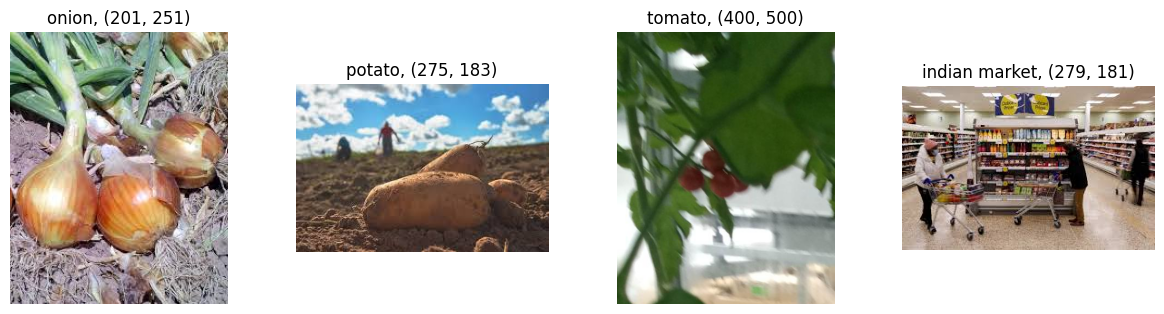

In [ ]:
plt.figure(figsize=(15, 12))

for i, (cls, img) in enumerate(image_dict.items()):

    ax = plt.subplot(3, 4, i + 1)
    ax.imshow(img)
    ax.set_title(f'{cls}, {img.size}')
    ax.axis("off")

plt.show()

<Figure size 1000x600 with 0 Axes>

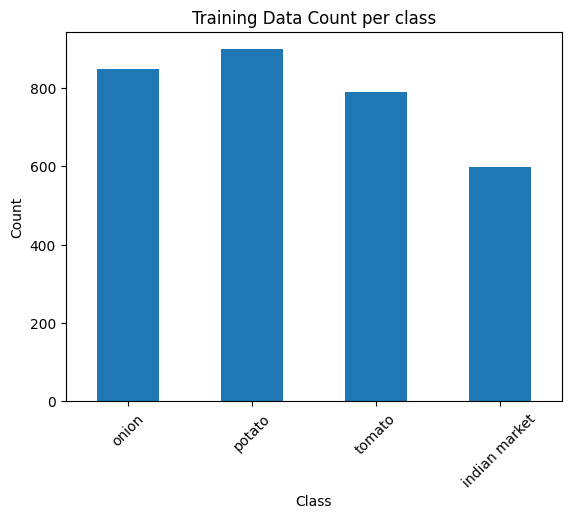

In [ ]:
df_count_train = pd.DataFrame(list(count_dict.items()), columns=['class', 'count'])

# print("Count of training samples per class:\n", df_count_train)

plt.figure(figsize=(10, 6))
df_count_train.plot(kind='bar', x='class', y='count', legend=False, title="Training Data Count per class")
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Data Loading

In [ ]:
# Define the directory where your training data is located
data_directory = "ninjacart_data/train"

# Set the batch size and validation split percentage
batch_size = 32
validation_split = 0.2  # 20% of the data will be used as a validation set
seed= 111
image_size= (224, 224) # resizes the image to 224x224 pixels

# Load the training data
train_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split= validation_split,
    subset= "training",
    seed= seed,
    shuffle= True,
    batch_size= batch_size,
    image_size= image_size
)

# Load the validation data
val_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split= validation_split,
    subset= "validation",
    seed= seed,
    shuffle= True,
    batch_size= batch_size,
    image_size= image_size
)

test_data_directory = "ninjacart_data/test"
test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_directory,
    shuffle= False,
    batch_size= batch_size,
    image_size= image_size
)

print('\nTrain, validation, and test datasets have been loaded.')

Found 3135 files belonging to 4 classes.
Using 2508 files for training.
Found 3135 files belonging to 4 classes.
Using 627 files for validation.
Found 351 files belonging to 4 classes.

Train, validation, and test datasets have been loaded.


Sample image shape: (224, 224, 3)


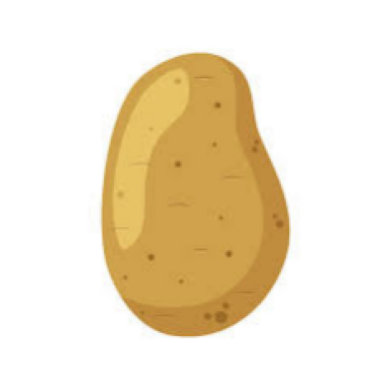

In [ ]:
for images, labels in train_data.take(1):
    # Take the first image from this batch
    sample_image = images[0].numpy()
    # Convert the image to a NumPy array and print its shape
    print("Sample image shape:", sample_image.shape)

    # Optionally, display the image using matplotlib
    import matplotlib.pyplot as plt
    plt.imshow(sample_image.astype("uint8"))
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [ ]:
# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(224, 224), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_data = train_data.map(lambda x, y: (data_preprocess(x), y))
val_data = val_data.map(lambda x, y: (data_preprocess(x), y))
test_data = test_data.map(lambda x, y: (data_preprocess(x), y))

Sample image shape: (224, 224, 3)


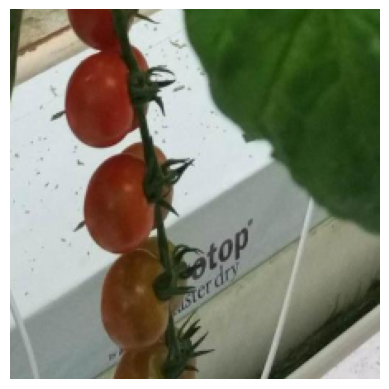

In [ ]:
for images, labels in train_data.take(1):
    # Take the first image from this batch
    sample_image = images[0].numpy()
    # Convert the image to a NumPy array and print its shape
    print("Sample image shape:", sample_image.shape)

    # Optionally, display the image using matplotlib
    import matplotlib.pyplot as plt
    plt.imshow(sample_image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

## Baseline model

* Train Accuracy: 99.36%
* Validation Accuracy: 81.02%
* Test Accuracy:78.06%

In [ ]:
num_classes = 4  # Change this to the number of classes in your dataset

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 10  # You can adjust this based on when you see the validation loss plateau
history = model.fit(train_data, validation_data=val_data, epochs=epochs)

Epoch 1/10
79/79 [==============================] - 15s 117ms/step - loss: 1.2893 - accuracy: 0.6176 - val_loss: 0.5965 - val_accuracy: 0.7911
Epoch 2/10
79/79 [==============================] - 11s 125ms/step - loss: 0.4337 - accuracy: 0.8381 - val_loss: 0.6030 - val_accuracy: 0.7927
Epoch 3/10
79/79 [==============================] - 10s 124ms/step - loss: 0.2862 - accuracy: 0.8911 - val_loss: 0.4261 - val_accuracy: 0.8421
Epoch 4/10
79/79 [==============================] - 10s 122ms/step - loss: 0.1338 - accuracy: 0.9597 - val_loss: 0.4901 - val_accuracy: 0.8357
Epoch 5/10
79/79 [==============================] - 11s 123ms/step - loss: 0.0794 - accuracy: 0.9781 - val_loss: 0.4848 - val_accuracy: 0.8501
Epoch 6/10
79/79 [==============================] - 11s 130ms/step - loss: 0.0443 - accuracy: 0.9868 - val_loss: 0.5424 - val_accuracy: 0.8517
Epoch 7/10
79/79 [==============================] - 11s 134ms/step - loss: 0.0382 - accuracy: 0.9912 - val_loss: 0.6104 - val_accuracy: 0.8373

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print('\nTest accuracy:', test_acc)

11/11 [==============================] - 2s 194ms/step - loss: 0.9960 - accuracy: 0.7806

Test accuracy: 0.7806267738342285


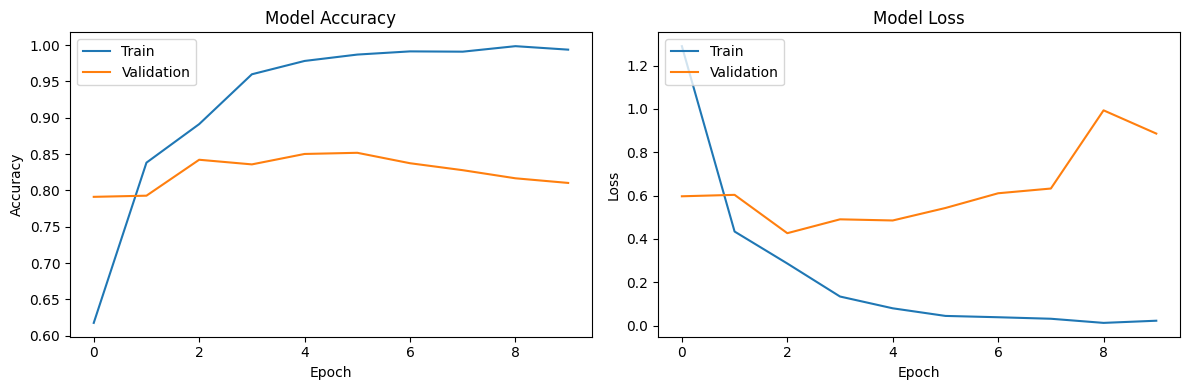

In [ ]:
# Set up a figure with two subplots in one row and two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 - 1s - 658ms/epoch - 658ms/step
1/1 - 0s - 136ms/epoch - 136ms/step
1/1 - 0s - 100ms/epoch - 100ms/step
1/1 - 0s - 140ms/epoch - 140ms/step
1/1 - 0s - 89ms/epoch - 89ms/step
1/1 - 0s - 98ms/epoch - 98ms/step
1/1 - 0s - 66ms/epoch - 66ms/step
1/1 - 0s - 82ms/epoch - 82ms/step
1/1 - 0s - 61ms/epoch - 61ms/step
1/1 - 0s - 40ms/epoch - 40ms/step
1/1 - 0s - 139ms/epoch - 139ms/step


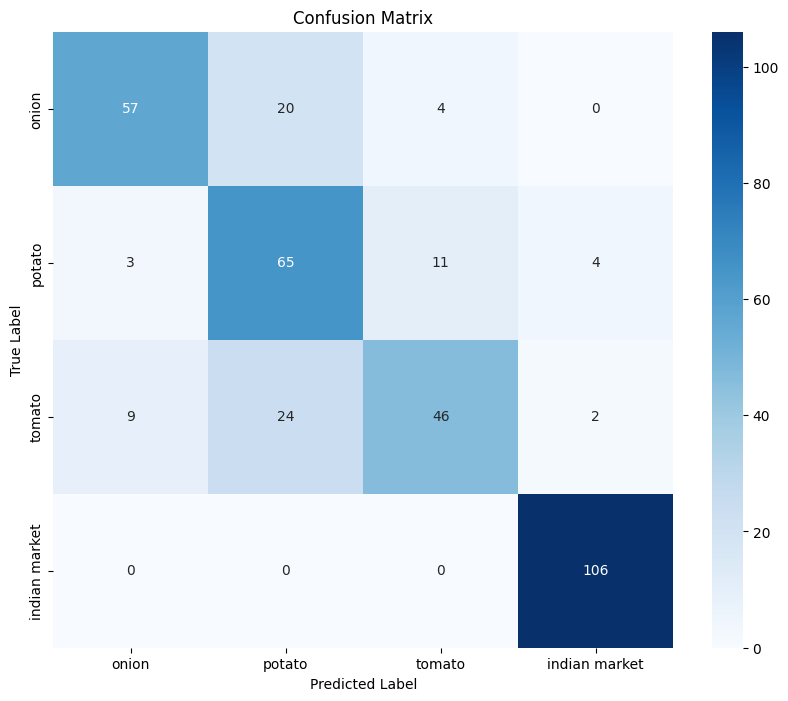

In [ ]:
# Generate predictions for test data
true_labels = []
pred_labels = []
for images, labels in test_data:
    preds = model.predict(images, verbose= 2)
    pred_labels.extend(np.argmax(preds, axis=-1))
    true_labels.extend(labels)

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= class_dirs, yticklabels= class_dirs)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
class_names= ['indian market', 'onion', 'potato', 'tomato']

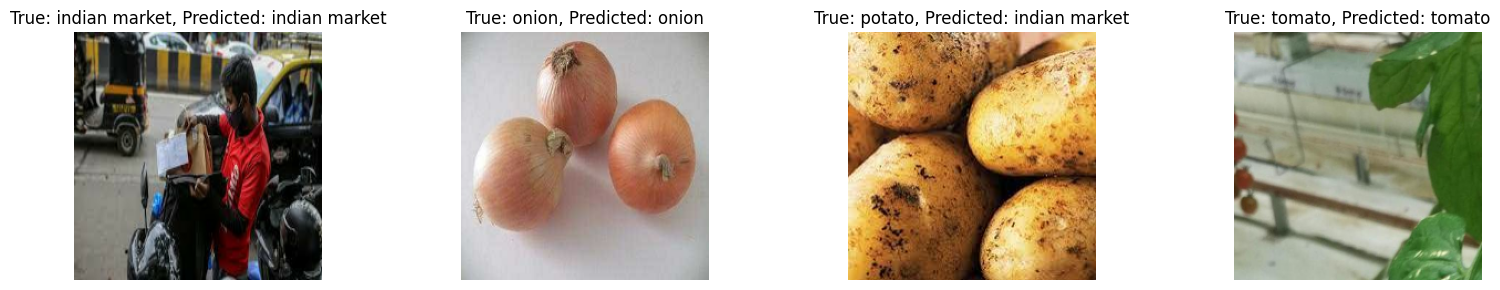

In [ ]:
random_images = {}
random_true_labels = {}
random_pred_labels = {}

# Iterate through the dataset to collect one random image per class
for class_index in range(num_classes):
    # Filter by class_index
    class_images = [(image.numpy(), label.numpy()) for image, label in test_data.unbatch() if label.numpy() == class_index]

    # Randomly select one image from this class
    image, label = random.choice(class_images)

    # Store the selected image and its true label
    random_images[class_index] = image
    random_true_labels[class_index] = label
    # Generate and store the predicted label
    pred_label = np.argmax(model.predict(tf.expand_dims(image, axis=0), verbose= 0), axis=-1)[0]
    random_pred_labels[class_index] = pred_label

# Plotting the images with their true and predicted labels
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(num_classes * 4, 3))

if num_classes == 1:  # If there's only one class, axes will not be an array
    axes = [axes]

for i in range(num_classes):
    image = random_images[i]
    true_label = random_true_labels[i]
    pred_label = random_pred_labels[i]

    axes[i].imshow(image)
    axes[i].axis('off')  # Hide the axis
    true_label_name = class_names[true_label]
    pred_label_name = class_names[pred_label]
    title = f"True: {true_label_name}, Predicted: {pred_label_name}"
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

## Baseline + Dropout + Batch Normalization + Average Pooling + Early Stopping

* Train Accuracy: 91.39 %
* Validation Accuracy: 86.76%
* Test Accuracy: 90.59%

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_data,
    validation_data= val_data,
    epochs=100,  # Set to a higher number as early stopping will halt the training appropriately
    callbacks=[early_stopping]
)

Epoch 1/100
79/79 [==============================] - 17s 157ms/step - loss: 0.8598 - accuracy: 0.6547 - val_loss: 1.2999 - val_accuracy: 0.4274
Epoch 2/100
79/79 [==============================] - 15s 175ms/step - loss: 0.6476 - accuracy: 0.7424 - val_loss: 1.3612 - val_accuracy: 0.2951
Epoch 3/100
79/79 [==============================] - 15s 181ms/step - loss: 0.5769 - accuracy: 0.7679 - val_loss: 1.6631 - val_accuracy: 0.2504
Epoch 4/100
79/79 [==============================] - 13s 147ms/step - loss: 0.5459 - accuracy: 0.7835 - val_loss: 1.6541 - val_accuracy: 0.2568
Epoch 5/100
79/79 [==============================] - 12s 140ms/step - loss: 0.5275 - accuracy: 0.7863 - val_loss: 1.5990 - val_accuracy: 0.3333
Epoch 6/100
79/79 [==============================] - 13s 155ms/step - loss: 0.4931 - accuracy: 0.8026 - val_loss: 0.7913 - val_accuracy: 0.6826
Epoch 7/100
79/79 [==============================] - 13s 155ms/step - loss: 0.4886 - accuracy: 0.8098 - val_loss: 0.9134 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print('\nTest accuracy:', test_acc)

11/11 [==============================] - 1s 129ms/step - loss: 0.2700 - accuracy: 0.9060

Test accuracy: 0.9059829115867615


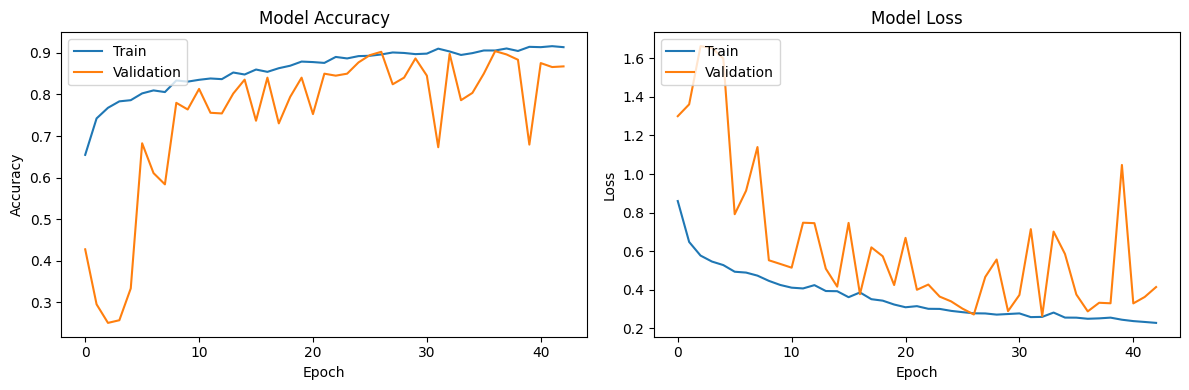

In [ ]:
# Set up a figure with two subplots in one row and two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

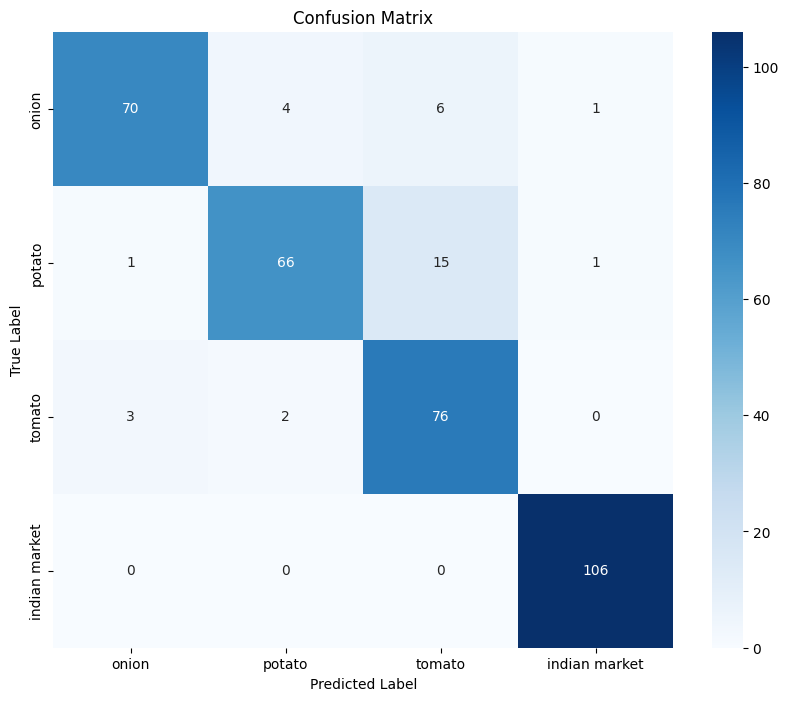

In [ ]:
# Generate predictions for test data
true_labels = []
pred_labels = []
for images, labels in test_data:
    preds = model.predict(images, verbose= 0)
    pred_labels.extend(np.argmax(preds, axis=-1))
    true_labels.extend(labels)

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= class_dirs, yticklabels= class_dirs)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

1/1 [==============================] - 0s 31ms/step


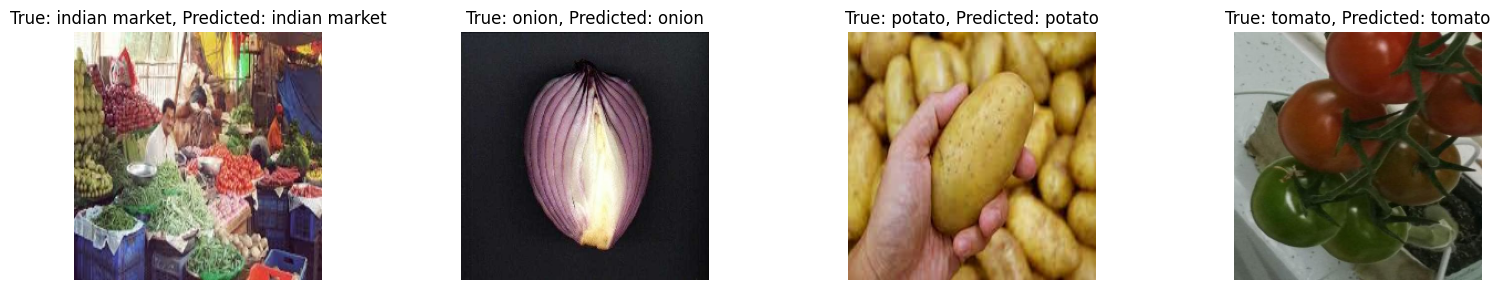

In [ ]:
random_images = {}
random_true_labels = {}
random_pred_labels = {}

# Iterate through the dataset to collect one random image per class
for class_index in range(num_classes):
    # Filter by class_index
    class_images = [(image.numpy(), label.numpy()) for image, label in test_data.unbatch() if label.numpy() == class_index]

    # Randomly select one image from this class
    image, label = random.choice(class_images)

    # Store the selected image and its true label
    random_images[class_index] = image
    random_true_labels[class_index] = label
    # Generate and store the predicted label
    pred_label = np.argmax(model.predict(tf.expand_dims(image, axis=0), verbose= 0), axis=-1)[0]
    random_pred_labels[class_index] = pred_label

# Plotting the images with their true and predicted labels
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(num_classes * 4, 3))

if num_classes == 1:  # If there's only one class, axes will not be an array
    axes = [axes]

for i in range(num_classes):
    image = random_images[i]
    true_label = random_true_labels[i]
    pred_label = random_pred_labels[i]

    axes[i].imshow(image)
    axes[i].axis('off')  # Hide the axis
    true_label_name = class_names[true_label]
    pred_label_name = class_names[pred_label]
    title = f"True: {true_label_name}, Predicted: {pred_label_name}"
    axes[i].set_title(title)

plt.tight_layout()
plt.show()


## Early Stopping + Learning Rate Scheduler

* Train Accuracy: 90.31%
* Validation Accuracy: 88.84%
* Test Accuracy: 90.31%

In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,    # Reduce learning rate by a factor of 0.2
    patience=3,    # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    min_lr=0.0001   # Lower bound on the learning rate
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,  # Set to a higher number, as callbacks will handle stopping
    callbacks= [early_stopping, lr_schedule]
)

Epoch 1/100
79/79 [==============================] - 18s 156ms/step - loss: 0.8623 - accuracy: 0.6503 - val_loss: 1.2778 - val_accuracy: 0.5008 - lr: 0.0010
Epoch 2/100
79/79 [==============================] - 12s 142ms/step - loss: 0.6695 - accuracy: 0.7420 - val_loss: 1.3794 - val_accuracy: 0.4514 - lr: 0.0010
Epoch 3/100
79/79 [==============================] - 13s 148ms/step - loss: 0.5870 - accuracy: 0.7723 - val_loss: 1.3151 - val_accuracy: 0.4689 - lr: 0.0010
Epoch 4/100
79/79 [==============================] - 12s 143ms/step - loss: 0.5783 - accuracy: 0.7739 - val_loss: 1.2195 - val_accuracy: 0.5311 - lr: 0.0010
Epoch 5/100
79/79 [==============================] - 13s 157ms/step - loss: 0.5383 - accuracy: 0.7791 - val_loss: 1.1587 - val_accuracy: 0.5327 - lr: 0.0010
Epoch 6/100
79/79 [==============================] - 13s 157ms/step - loss: 0.5202 - accuracy: 0.7899 - val_loss: 1.4275 - val_accuracy: 0.4530 - lr: 0.0010
Epoch 7/100
79/79 [==============================] - 14s 1

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print('\nTest accuracy:', test_acc)

11/11 [==============================] - 2s 164ms/step - loss: 0.2724 - accuracy: 0.9031

Test accuracy: 0.9031339287757874


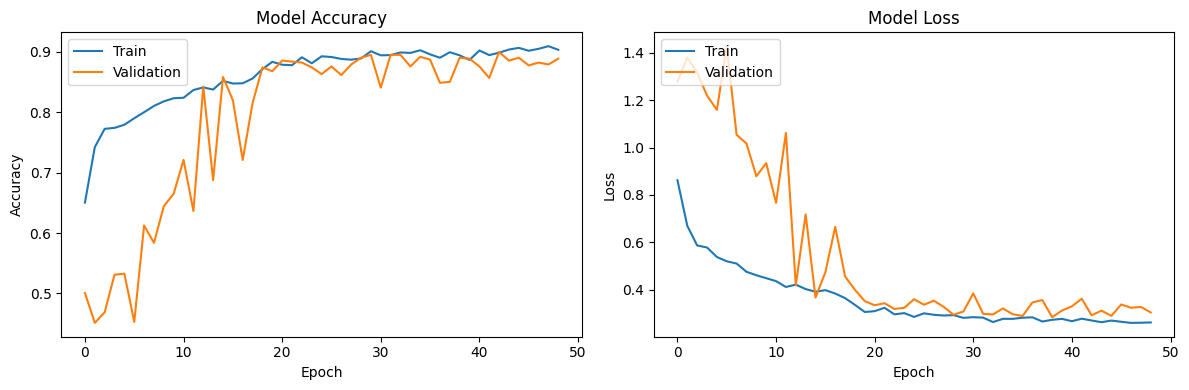

In [ ]:
# Set up a figure with two subplots in one row and two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

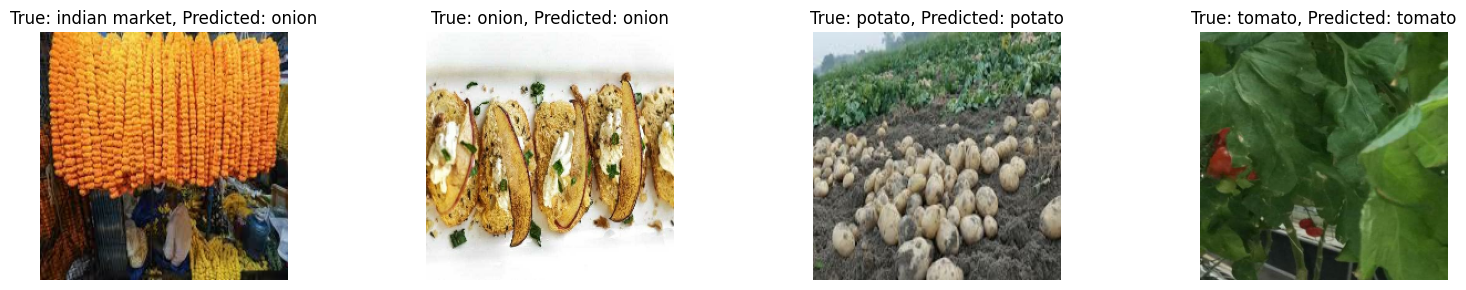

In [ ]:
random_images = {}
random_true_labels = {}
random_pred_labels = {}

# Iterate through the dataset to collect one random image per class
for class_index in range(num_classes):
    # Filter by class_index
    class_images = [(image.numpy(), label.numpy()) for image, label in test_data.unbatch() if label.numpy() == class_index]

    # Randomly select one image from this class
    image, label = random.choice(class_images)

    # Store the selected image and its true label
    random_images[class_index] = image
    random_true_labels[class_index] = label
    # Generate and store the predicted label
    pred_label = np.argmax(model.predict(tf.expand_dims(image, axis=0), verbose= 0), axis=-1)[0]
    random_pred_labels[class_index] = pred_label

# Plotting the images with their true and predicted labels
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(num_classes * 4, 3))

if num_classes == 1:  # If there's only one class, axes will not be an array
    axes = [axes]

for i in range(num_classes):
    image = random_images[i]
    true_label = random_true_labels[i]
    pred_label = random_pred_labels[i]

    axes[i].imshow(image)
    axes[i].axis('off')  # Hide the axis
    true_label_name = class_names[true_label]
    pred_label_name = class_names[pred_label]
    title = f"True: {true_label_name}, Predicted: {pred_label_name}"
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

## Transfer Learning (MobileNet V2)

* Train Accuracy: 96.97%
* Validation Accuracy:  94.74%
* Test Accuracy: 91.25%


In [ ]:
# Load MobileNetV2 without the top layer (classifier)
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base_model
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)  # A dense layer as hidden layer
x = layers.Dropout(0.5)(x)  # Dropout for regularization
predictions = layers.Dense(4, activation='softmax')(x)  # New output layer

model = models.Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    'ninjacart_data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    'ninjacart_data/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    seed=42
)

Found 2511 images belonging to 4 classes.
Found 624 images belonging to 4 classes.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10
78/78 [==============================] - 80s 977ms/step - loss: 0.4202 - accuracy: 0.8386 - val_loss: 0.2401 - val_accuracy: 0.8947
Epoch 2/10
78/78 [==============================] - 45s 581ms/step - loss: 0.2130 - accuracy: 0.9221 - val_loss: 0.1968 - val_accuracy: 0.9326
Epoch 3/10
78/78 [==============================] - 46s 595ms/step - loss: 0.1602 - accuracy: 0.9407 - val_loss: 0.1807 - val_accuracy: 0.9457
Epoch 4/10
78/78 [==============================] - 49s 628ms/step - loss: 0.1327 - accuracy: 0.9520 - val_loss: 0.1552 - val_accuracy: 0.9408
Epoch 5/10
78/78 [==============================] - 47s 598ms/step - loss: 0.1062 - accuracy: 0.9637 - val_loss: 0.1526 - val_accuracy: 0.9408
Epoch 6/10
78/78 [==============================] - 46s 589ms/step - loss: 0.1073 - accuracy: 0.9585 - val_loss: 0.1656 - val_accuracy: 0.9556
Epoch 7/10
78/78 [==============================] - 47s 600ms/step - loss: 0.0975 - accuracy: 0.9641 - val_loss: 0.1414 - val_accuracy: 0.9655

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'ninjacart_data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 351 images belonging to 4 classes.


In [ ]:
loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

10/10 [==============================] - 1s 138ms/step - loss: 0.2492 - accuracy: 0.9125
Test accuracy: 91.25%


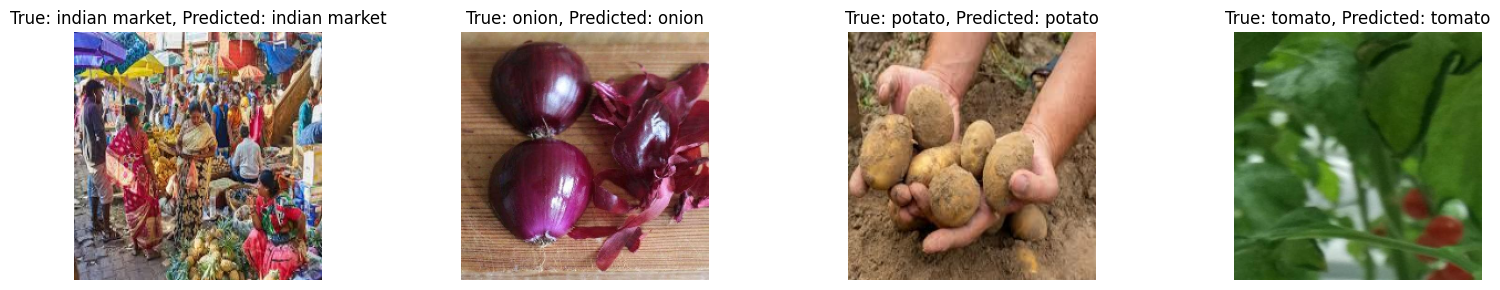

In [ ]:
random_images = {}
random_true_labels = {}
random_pred_labels = {}

# Iterate through the dataset to collect one random image per class
for class_index in range(num_classes):
    # Filter by class_index
    class_images = [(image.numpy(), label.numpy()) for image, label in test_data.unbatch() if label.numpy() == class_index]

    # Randomly select one image from this class
    image, label = random.choice(class_images)

    # Store the selected image and its true label
    random_images[class_index] = image
    random_true_labels[class_index] = label
    # Generate and store the predicted label
    pred_label = np.argmax(model.predict(tf.expand_dims(image, axis=0), verbose= 0), axis=-1)[0]
    random_pred_labels[class_index] = pred_label

# Plotting the images with their true and predicted labels
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(num_classes * 4, 3))

if num_classes == 1:  # If there's only one class, axes will not be an array
    axes = [axes]

for i in range(num_classes):
    image = random_images[i]
    true_label = random_true_labels[i]
    pred_label = random_pred_labels[i]

    axes[i].imshow(image)
    axes[i].axis('off')  # Hide the axis
    true_label_name = class_names[true_label]
    pred_label_name = class_names[pred_label]
    title = f"True: {true_label_name}, Predicted: {pred_label_name}"
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

## Transfer Learning - Fine Tuning

In [ ]:
# Unfreeze the base_model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any layer, so that your changes
# are taken into account
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training (fine-tune)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

Epoch 1/10
78/78 [==============================] - 77s 636ms/step - loss: 0.3635 - accuracy: 0.8709 - val_loss: 0.1926 - val_accuracy: 0.9408
Epoch 2/10
78/78 [==============================] - 49s 624ms/step - loss: 0.2144 - accuracy: 0.9242 - val_loss: 0.2218 - val_accuracy: 0.9408
Epoch 3/10
78/78 [==============================] - 48s 609ms/step - loss: 0.1738 - accuracy: 0.9415 - val_loss: 0.2305 - val_accuracy: 0.9276
Epoch 4/10
78/78 [==============================] - 49s 633ms/step - loss: 0.1553 - accuracy: 0.9476 - val_loss: 0.1967 - val_accuracy: 0.9375
Epoch 5/10
78/78 [==============================] - 48s 611ms/step - loss: 0.1288 - accuracy: 0.9568 - val_loss: 0.1789 - val_accuracy: 0.9441
Epoch 6/10
78/78 [==============================] - 48s 612ms/step - loss: 0.1304 - accuracy: 0.9492 - val_loss: 0.1501 - val_accuracy: 0.9589
Epoch 7/10
78/78 [==============================] - 49s 631ms/step - loss: 0.1250 - accuracy: 0.9548 - val_loss: 0.1718 - val_accuracy: 0.9424

In [ ]:
loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

10/10 [==============================] - 1s 137ms/step - loss: 0.3315 - accuracy: 0.8875
Test accuracy: 88.75%


## Testing on Random Samples

In [ ]:
import requests
from PIL import Image
from io import BytesIO

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image

class_names = ['indian market', 'onion', 'potato', 'tomato']

In [ ]:
def load_and_predict(image_url):

  response = requests.get(image_url)

  image = Image.open(BytesIO(response.content))

  image_resized = image.resize((224, 224))
  image_array = keras_image.img_to_array(image_resized)
  image_array = np.expand_dims(image_array, axis=0)
  image_processed = preprocess_input(image_array)

  return image_processed

In [ ]:
image_url= 'https://images.immediate.co.uk/production/volatile/sites/30/2019/08/Onion-72ea178.jpg?quality=90&webp=true&resize=300,272'

predictions = model.predict(load_and_predict(image_url))
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 22ms/step


In [ ]:
predicted_class

array([1])

In [ ]:
print("Predicted class:", class_names[predicted_class[0]])

Predicted class: onion
